In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/qvp_env/share/proj/'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, metrics, wait
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, progress
import pyart
import netCDF4
import xarray
import tempfile
import shutil
from netCDF4 import num2date
import json
#from time import strftime, sleep
import datetime
import glob
import subprocess
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
"""
pyart.retrieve.quasi_vertical_profile
=====================================

Retrieval of QVPs from a radar object

.. autosummary::
    :toctree: generated/

    quasi_vertical_profile

"""

import numpy as np

from pyart.core import antenna_to_cartesian



def quasi_vertical_profile(radar, fields = None, gatefilter = None):
    
    """
    Quasi Vertical Profile.
    
    Creates a QVP object object containing fields from a radar object that can
    be used to plot and produce the quasi vertical profile
    
    
    Parameters
    ----------
    radar : Radar
        Radar object used.
    field : string
        Radar field to use for QVP calculation.
    radar_tilt: float
        Desired radar tilt angle 
    
    Other Parameters
    ----------------
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the import qvp calculation
        
    Returns
    -------
    qvp : Dictonary
        A quasi vertical profile object containing fields
        from a radar object
    
    
    
    References
    ----------
    Troemel, S., M. Kumjian, A. Ryzhkov, and C. Simmer, 2013: Backscatter 
    differential phase – estimation and variability. J. Appl. Meteor. Clim.. 
    52, 2529 – 2548.

    Troemel, S., A. Ryzhkov, P. Zhang, and C. Simmer, 2014: Investigations 
    of backscatter differential phase in the melting layer. J. Appl. Meteorol. 
    Clim. 53, 2344 – 2359.

    Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Troemel, 
    C. Simmer, 2015: Quasi-vertical profiles – a new way to look at polarimetric 
    radar data. Submitted to J. Atmos. Oceanic Technol.
    
    """
    
    qvp = {}
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    print(radar.fixed_angle['data'])
    print(radar.elevation['data'][-1])
    
    radar_slice = radar.get_slice(index)
    
    if fields is None:
        fields = radar.fields

        for field in fields:
            if gatefilter is not None:
                get_field = radar.get_field(index, field)
                this_field = np.ma.masked_where(gatefilter.gate_excluded[radar_slice], 
                                                get_field)
                this_field = np.ma.mean(this_field, axis = 0)
            else: 
                this_field = radar.get_field(index, field).mean(axis = 0)
            qvp.update({field:this_field})

    else:
        if gatefilter is not None:
            this_field = radar.get_field(index, fields)
            this_field = np.ma.masked_where(gatefilter.gate_excluded[radar_slice], 
                                            this_field)
            this_field = np.ma.mean(this_field, axis = 0)
        else: 
            this_field = radar.get_field(index, field).mean(axis = 0)
            
        qvp.update({fields:this_field})
        
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                            radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

In [3]:
def run_qvp(radar_file_path, fields, gatefilter):
    """For dask we need the radar plotting routines all in one subroutine"""
    try:
        radar = pyart.io.read(radar_file_path)
    except OSError:
        return
    
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    
    qvp = quasi_vertical_profile(radar, fields=fields, gatefilter=gatefilter)
    
    
    data = xarray.Dataset()
    data['time'] = time
    data['height'] = qvp['height']
    data['total_power']= qvp['total_power']
    data['reflectivity'] = qvp['reflectivity']
    data['velocity'] = qvp['velocity']
    data['spectrum_width'] = qvp['spectrum_width']
    data['differential_reflectivity'] = qvp['differential_reflectivity']
    data['specific_differential_phase'] = qvp['specific_differential_phase']
    data['cross_correlation_ratio'] = qvp['cross_correlation_ratio']
    data['normalized_coherent_power'] = qvp['normalized_coherent_power']
    data['differential_phase'] = qvp['differential_phase']
    
    data.to_netcdf('/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_' + str(time) + '.nc')
    data.close()
    del radar
    del qvp

    return

In [4]:
radar_path = '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004'
#fields = 'reflectivity'
fields = None
gatefilter = None
#radar_tilt = 20.0

In [5]:
if os.path.isdir(radar_path):
    radar_files = glob.glob(radar_path + '/**/*', recursive=True)

elif os.path.isfile(radar_path):
    with open(radar_path) as f:
        radar_files = f.readlines()
    radar_files = [x.strip() for x in radar_files]
else:
    raise IOError('The specified radar path does not exist!')

In [6]:
radar_files

['/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.161101.mnt.XSW171004150005.RAWCKX9.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.221101.mnt.XSW171004212004.RAWCKYE.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.211101.mnt.XSW171004201004.RAWCKY7.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.041102.mnt.XSW171004033004.RAWCKV6.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.171101.mnt.XSW171004165005.RAWCKXL.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.161101.mnt.XSW171004152005.RAWCKXB.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.161101.mnt.XSW171004153004.RAWCKXC.maint',
 '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/sgpxsaprI5.00.20171004.151102.mnt.XSW171004144004.RAWCKX7.maint',
 '/lcrc/group/ea

In [20]:
cluster = SLURMCluster(cores=8, job_cpu=8, walltime='01:00:00', memory='128GB', 
                      local_dir='/home/jhemedinger/dask_worker_space/', project='ACPC')
                     #scheduler_file='/home/zsherman/scheduler.json'
cluster.scale(8)         # Ask for ten workers
client = Client(cluster)  # Connect this local process to remote workers

In [21]:
cluster

In [22]:
client

Client Scheduler: tcp://140.221.70.6:38097 Dashboard: http://140.221.70.6:44108/status,Cluster Workers: 1 Cores: 8 Memory: 128.00 GB


In [23]:
def com():
    os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/qvp_env/share/proj/'
    #from mpl_toolkits.basemap import Basemap
    return os.environ['PROJ_LIB']
client.run(com)

{'tcp://10.70.130.91:39836': '/home/jhemedinger/anaconda3/envs/qvp_env/share/proj/'}

In [24]:
the_bag = db.from_sequence(radar_files)
the_function = lambda x: run_qvp(x, fields=fields, gatefilter=gatefilter)
futures = the_bag.map(the_function)

In [25]:
futures.compute()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [27]:
cluster.stop_all_jobs()

In [28]:
files = glob.glob('/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/*')
files.sort()
print(files)

['/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:00:09.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:10:08.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:20:06.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:30:24.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:40:22.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-03T23:50:20.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:00:19.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:10:17.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:20:15.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:30:13.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:40:12.nc', '/lcrc/group/earthscience/radar/xsapr_sgp/vads/qvp_out/qvp_2017-10-04T00:50

In [29]:
len(files)

144

In [30]:
total_power = []
reflectivity = []
velocity = []
spectrum_width = []
differential_reflectivity = []
specific_differential_phase = []
cross_correlation_ratio = []
differential_phase = []
normalized_coherent_power = []
qtime = []
height = []
#rang = []

In [32]:
for file in files:
    ds = netCDF4.Dataset(file)
    tp = ds['total_power'][:]
    ref = ds['reflectivity'][:]
    vel = ds['velocity'][:]
    sw = ds['spectrum_width'][:]
    zdr = ds['differential_reflectivity'][:]
    kdp = ds['specific_differential_phase'][:]
    phv = ds['cross_correlation_ratio'][:]
    dp = ds['differential_phase'][:]
    ncp = ds['normalized_soherent_power'][:]
    time = ds['time'][:]
    hght = ds['height'][:]
    #ran = ds['range'][:]
    
    total_power.append(tp)
    reflectivity.append(ref)
    velocity.append(vel)
    spectrum_width.append(sw)
    differential_reflectivity.append(zdr)
    specific_differential_phase.append(kdp)
    cross_correlation_ratio.append(phv)
    differential_phase.append(dp)
    normalized_coherent_power.append(ncp)
    qtime.append(time)
    height.append(hght)
    #rang.append(ran)
    
new_tp = np.array(total_power)
new_ref = np.array(reflectivity)
new_vel = np.array(velocity)
new_sq = np.array(spectrum_width)
new_zdr = np.array(differential_reflectivity)
new_kdp = np.array(specific_differential_phase)
new_phv = np.array(cross_correlation_ratio)
new_dp = np.array(differential_phase)
new_ncp = np.array(normalized_coherent_power)
new_time = np.array(qtime, dtype='datetime64[ns]')
#new_height = np.array(height)
new_height = np.array(hght)
#new_range = np.array(rang)

In [33]:
new_ref.shape

(144, 501)

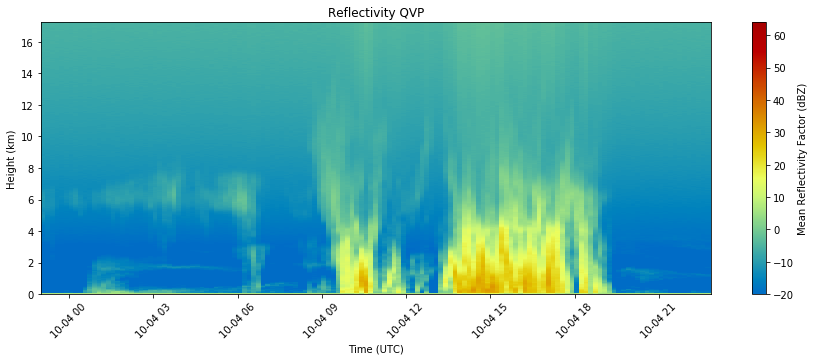

In [34]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_ref.transpose(), 
                     cmap=cmap, vmin=-20, vmax=64)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Reflectivity Factor (dBZ)')
#plt.savefig('ref_with_gate_id_zdr>1gatefilter.png', dpi=300)
plt.show()